In [75]:
import numpy as np
from astropy.io import fits
from scipy import signal
from matplotlib import pyplot as plt

# matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.3
plt.rcParams['font.family'] = 'Fira Code'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

In [76]:
#load perseus channels
perseus = np.loadtxt('SLICE_PERSEUS.csv', delimiter=',', dtype=float).astype(int).astype(bool)
print(np.where(perseus == True))
R = np.loadtxt('distance_channels.csv', delimiter=',', dtype=float)[perseus]
pics = fits.open('full_cube.fits')[0].data[perseus]

(array([162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183]),)


In [77]:
#convert galacto-centric distances to source-earth distances
global R0, T0, l, b, dl, d, dx

#position of the sun
R0 = 8.34
T0 = 240

#line of sight
l = 80.75 * np.pi / 180
b = 0

cosl = np.cos(l)
d = R0*cosl + np.sqrt(
  (cosl*R0)**2
  + R**2
  - R0**2
)

#convert distance to px
dl = 5e-3 * np.pi / 180
dx = d * dl

print(d, dx)

[7.65454969 7.58666243 7.51886951 7.45116015 7.38352336 7.31594794
 7.24842246 7.18093523 7.11347429 7.04602738 6.97858193 6.91112504
 6.84364339 6.77612332 6.70855068 6.64091089 6.57318884 6.50536888
 6.43743477 6.36936961 6.30115583 6.23277509] [0.00066799 0.00066206 0.00065615 0.00065024 0.00064433 0.00063844
 0.00063254 0.00062665 0.00062077 0.00061488 0.000609   0.00060311
 0.00059722 0.00059133 0.00058543 0.00057953 0.00057362 0.0005677
 0.00056177 0.00055583 0.00054988 0.00054391]


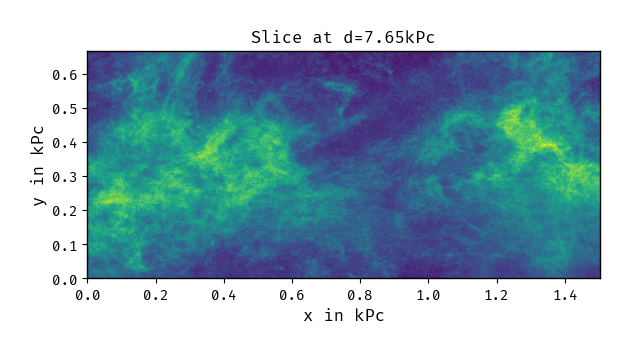

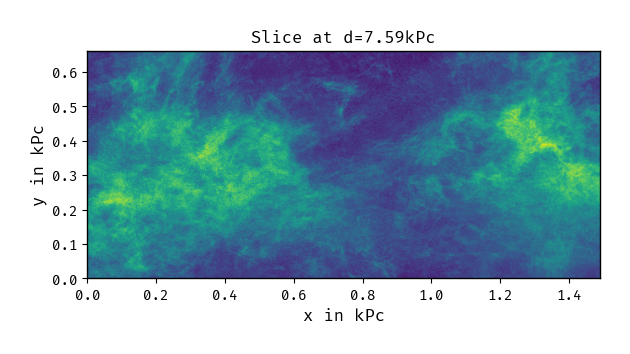

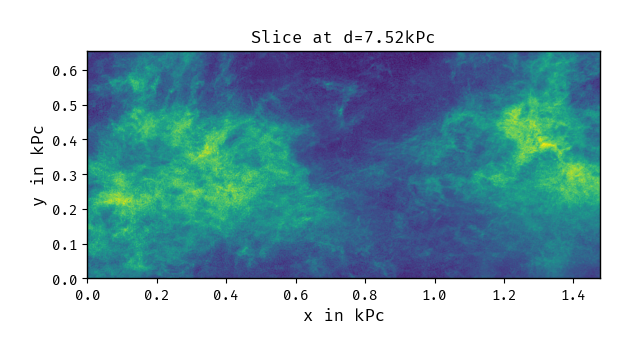

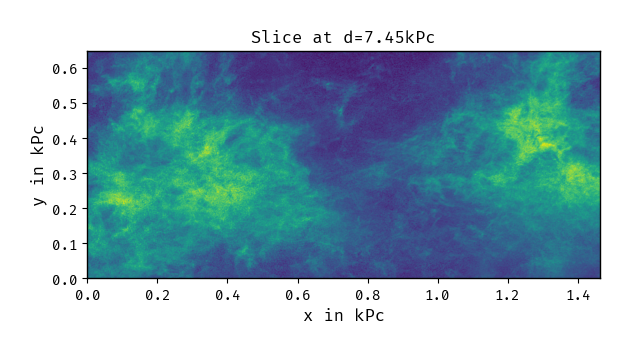

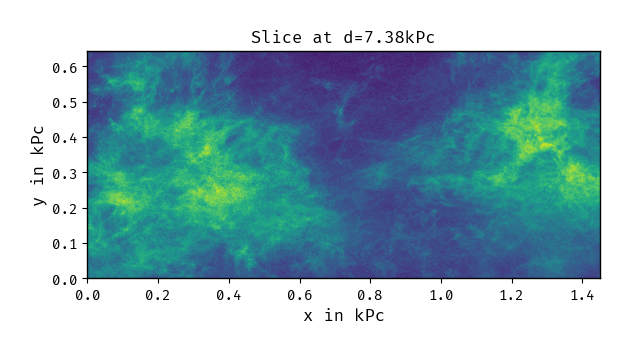

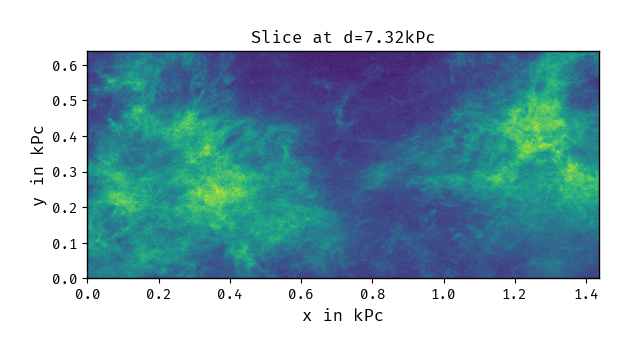

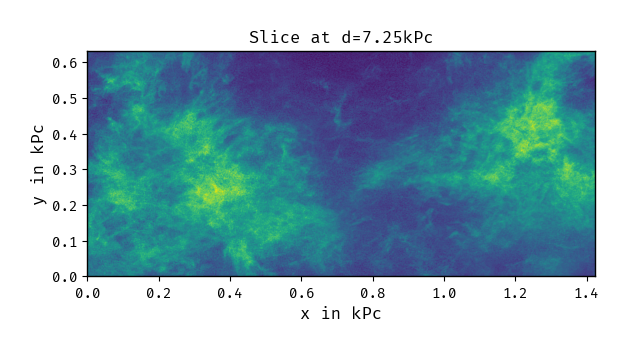

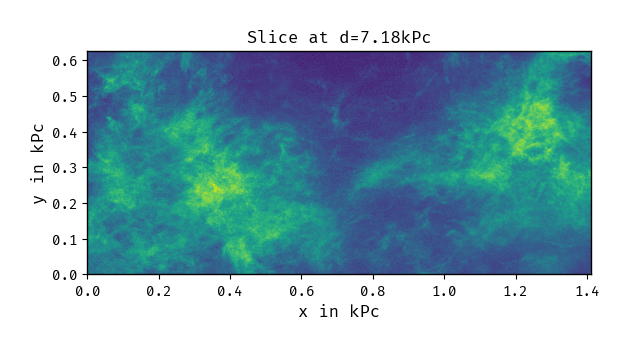

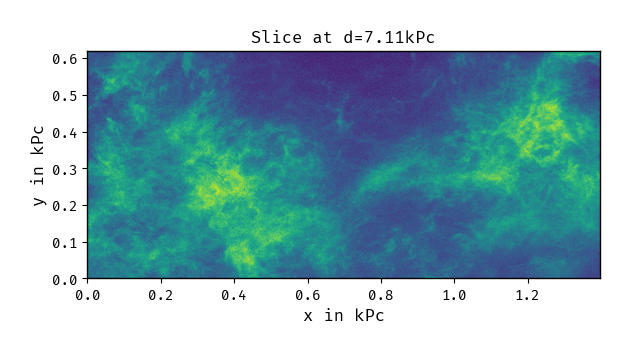

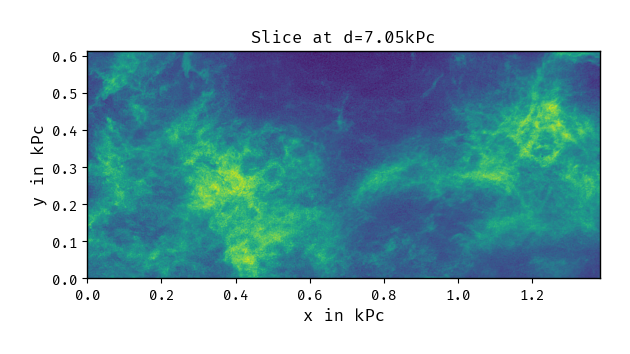

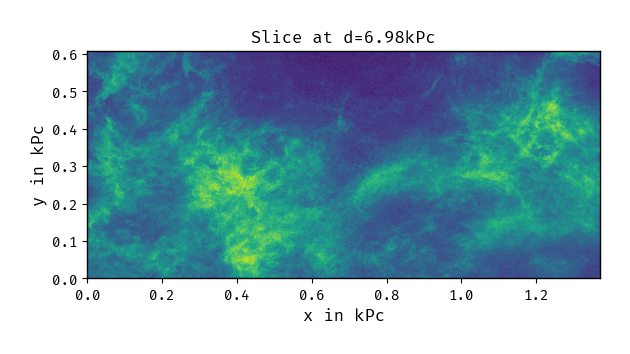

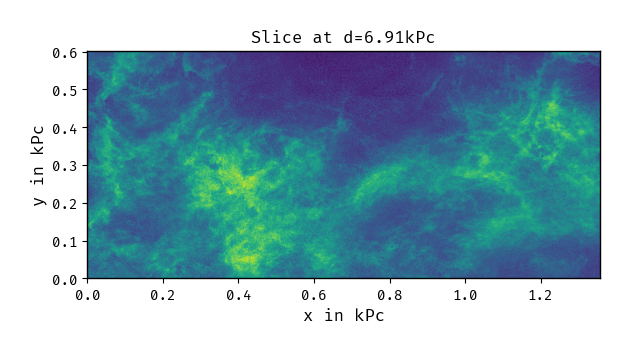

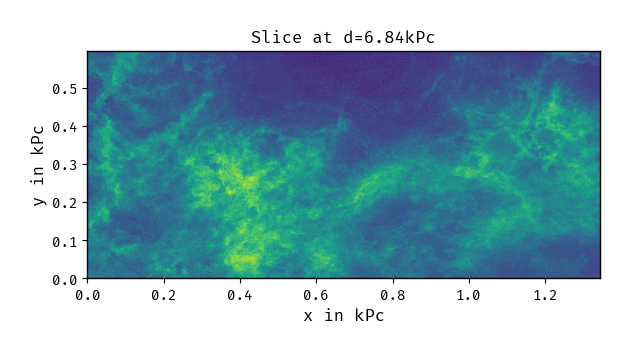

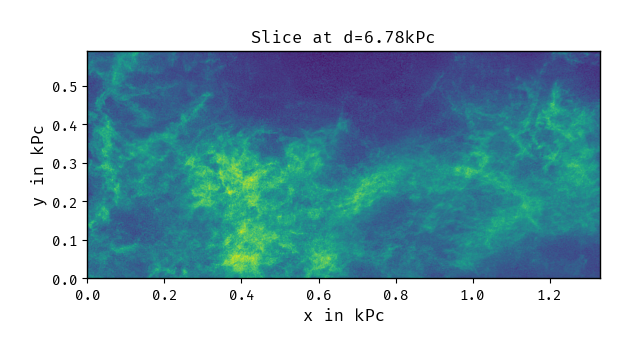

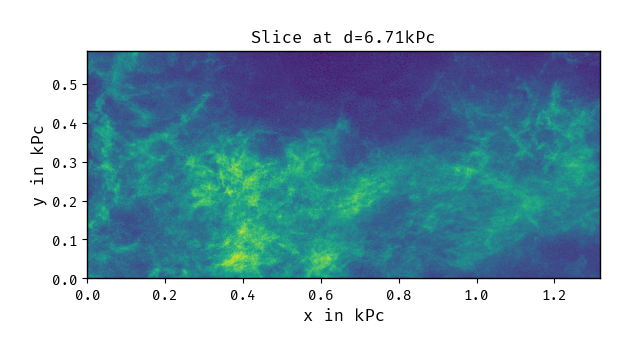

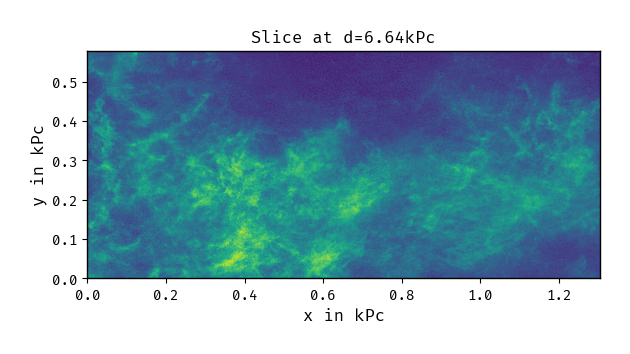

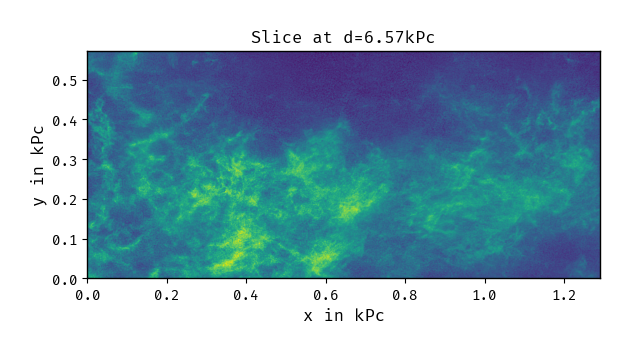

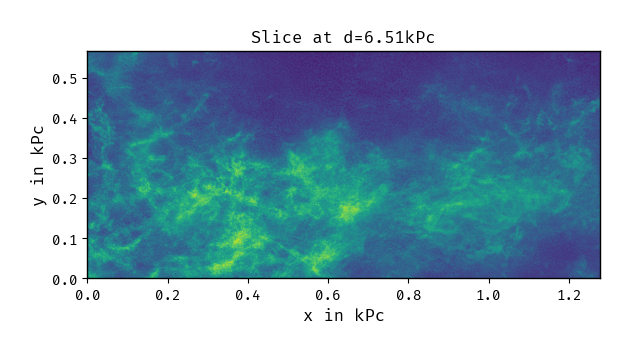

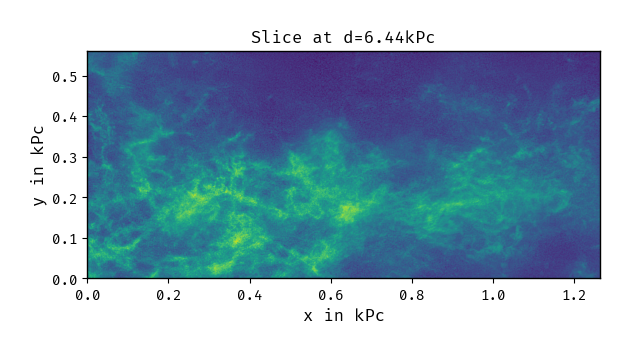

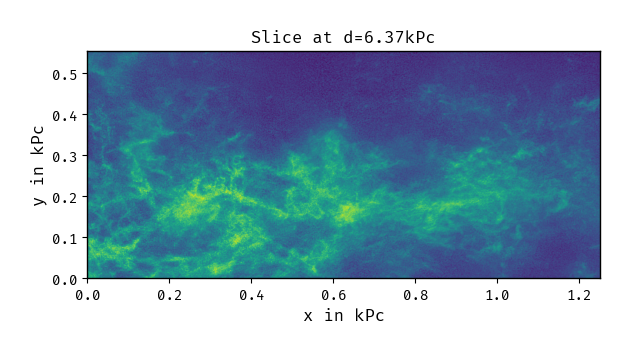

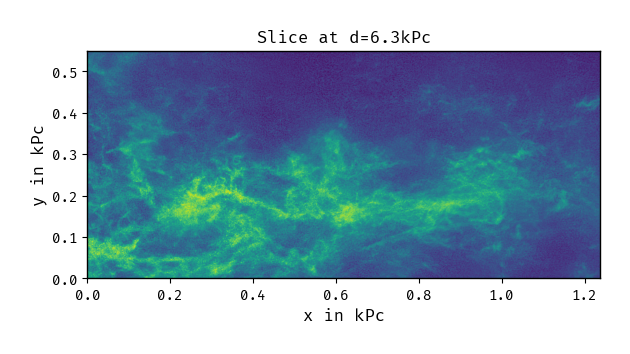

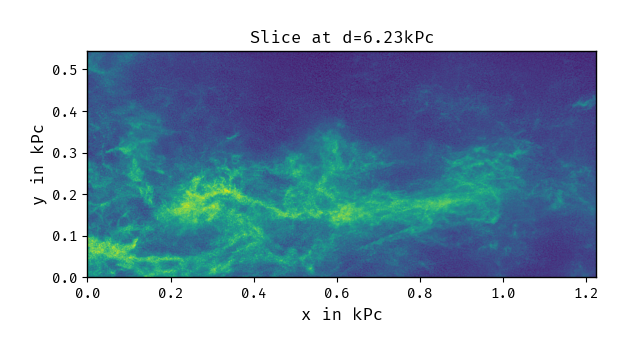

In [82]:
#show some perseus channels
for pic, d1, dx1 in zip(pics, d, dx):
  extent = (0, dx1*pic.shape[1], 0, dx1*pic.shape[0])
  plt.imshow(pic, extent=extent)
  plt.xlabel("x in kPc")
  plt.ylabel("y in kPc")
  plt.title(f"Slice at d={round(d1, 2)}kPc")
  plt.show()

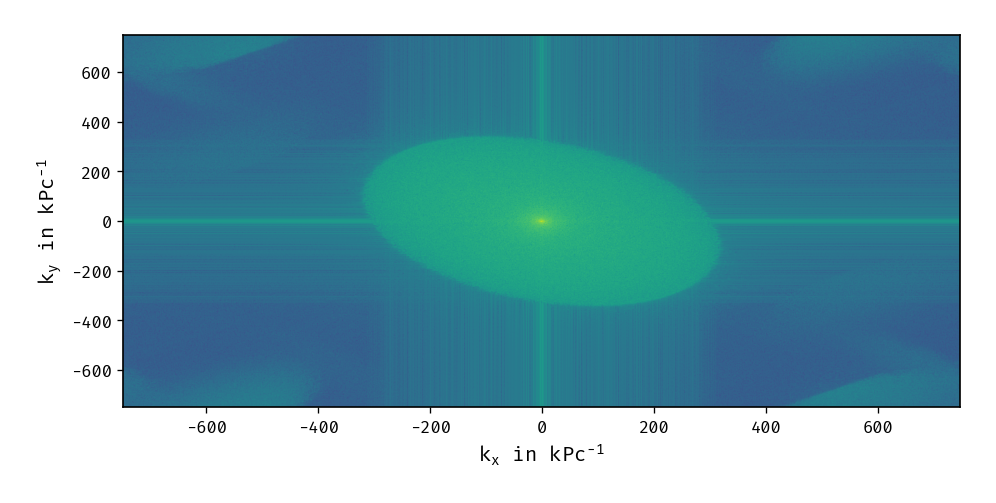

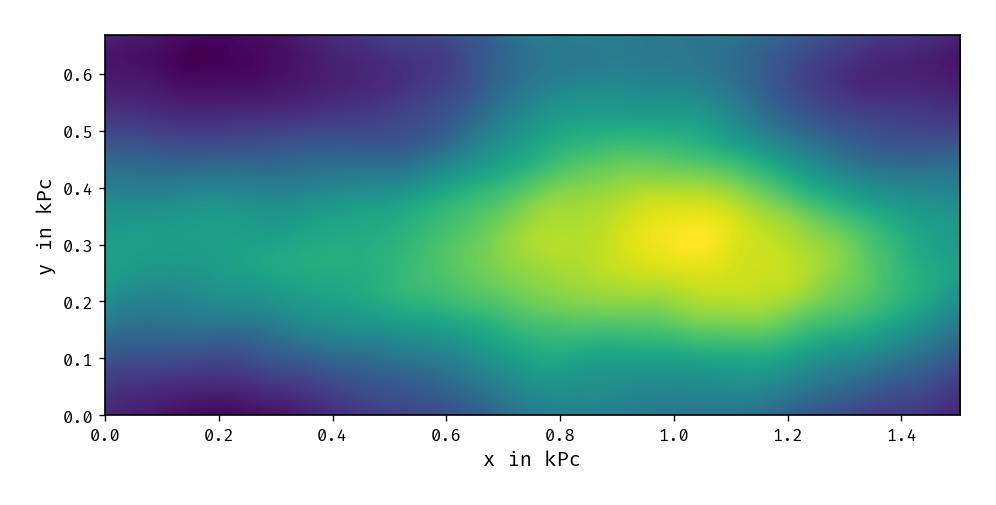

In [79]:
def high_pass_filter(fourier, cut_off):
    filter = np.ones(fourier.shape)
    mid = np.array(filter.shape) // 2
    print(f"mid={mid}")
    
    #create circle of zeros around middle
    for i, col in enumerate(filter):
        for j, item in enumerate(col):
            d = np.sqrt((mid[0] - i)**2 + (mid[1] - j)**2)
            if d < cut_off: filter[i,j] = 0
    
    #plot filter
    plt.figure(figsize=(8, 8), dpi=120)
    plt.imshow(filter)
    plt.title("high-pass filter")
    plt.show()
    
    return fourier * filter

def calc_xi(pic, dx: float, filter=False, save=False):
    #FT van overdensity
    dk = np.fft.fft2(pic)
    dk = np.fft.fftshift(dk)
    
    #calc freqs
    freqs = np.fft.fftfreq(pic.shape[0], dx)
    extent = (np.min(freqs), np.max(freqs), np.min(freqs), np.max(freqs))
    aspect_ratio = pic.shape[0] / pic.shape[1]
    
    #filter
    if filter: dk = high_pass_filter(dk, 10)

    #tweepuntscorrelatiefunctie is convolutie van overdensity met zichzelf
    dk2 = dk * dk
    plt.figure(figsize=(8, 8), dpi=120)
    plt.imshow(np.log(abs(dk2)), extent=extent, aspect=aspect_ratio)
    plt.xlabel("$k_x$ in $kPc^{-1}$")
    plt.ylabel("$k_y$ in $kPc^{-1}$")
    plt.show()
    if save: plt.imsave("fourier.png", np.log(abs(dk2)))

    dr2 = np.abs(np.fft.ifft2(dk2))
    dr2 = np.fft.ifftshift(dr2)

    #We hebben nu een symmetrisch beeld van de convolutie (als het goed is)
    plt.figure(figsize=(8, 8), dpi=120)
    extent = (0, dx*pic.shape[1], 0, dx*pic.shape[0])
    plt.imshow(dr2, extent=extent)
    plt.xlabel("x in kPc")
    plt.ylabel("y in kPc")
    plt.show()
    if save: plt.imsave("2p_correlation.png", dr2)
    return dr2

#Bereken de tweepuntsautocorrelatiefunctie
delta_r0 = pics[0]
xi0 = calc_xi(delta_r0, dx[0], save=True)

(1000, 2250)


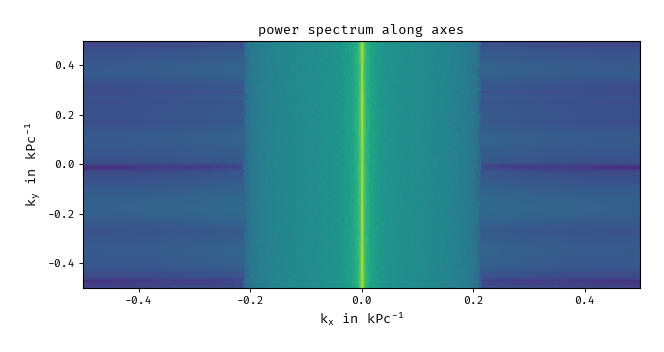

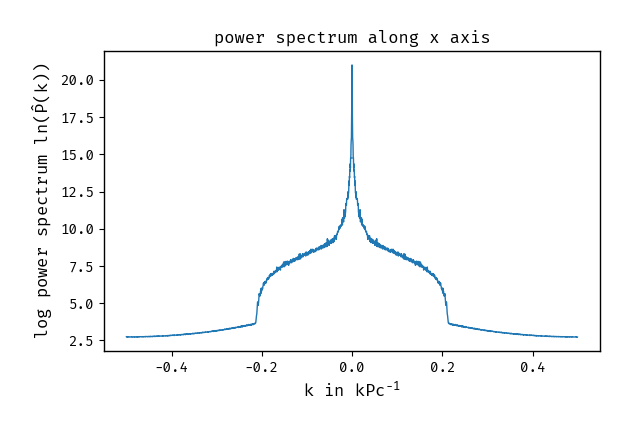

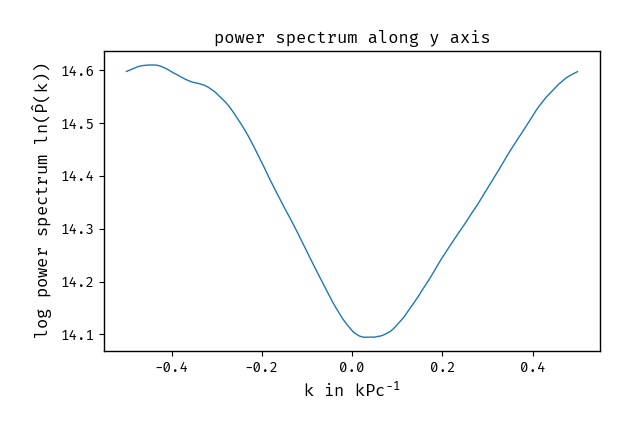

/tmp/ipykernel_18760/2590637878.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


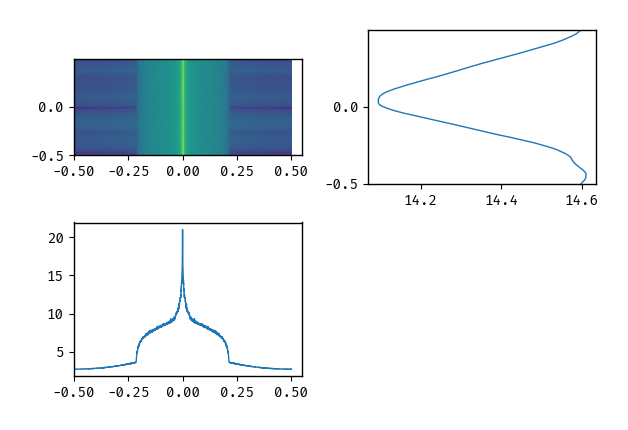

In [80]:
def calc_power_spec(xi, dx, save=False):
  Pk2d = np.abs(np.fft.ifftshift(np.fft.ifft(xi)))
  print(Pk2d.shape)
  
  #calc freqs
  freqs = np.fft.fftfreq(xi.shape[0], dx)
  extent = (np.min(freqs), np.max(freqs), np.min(freqs), np.max(freqs))
  aspect_ratio = xi.shape[0] / xi.shape[1]
  
  plt.figure(figsize=(8, 8), dpi=80)
  plt.imshow(np.log(Pk2d), extent=extent, aspect=aspect_ratio)
  plt.title("power spectrum along axes")
  plt.xlabel("$k_x$ in $kPc^{-1}$")
  plt.ylabel("$k_y$ in $kPc^{-1}$")
  if save: plt.imsave("2d_psp.png", np.log(Pk2d))
  plt.show()
  
  #de 2d plot is eigenlĳk al 1d, dus sommeren over 1 as is prima
  Pk1dx = np.sum(Pk2d, 0)
  Pk1dy = np.sum(Pk2d, 1)
  ky = np.fft.fftfreq(len(Pk1dy), dx)
  kx = np.fft.fftfreq(len(Pk1dx), dx)

  plt.figure(figsize=(6, 4))
  plt.plot(sorted(kx), np.log(Pk1dx))
  plt.xlabel("k in $kPc^{-1}$")
  plt.ylabel("log power spectrum $\ln(\hat{P}(k))$")
  plt.title("power spectrum along x axis")
  #plt.xscale("log")
  plt.show()
  
  plt.figure(figsize=(6, 4))
  plt.plot(sorted(ky), np.log(Pk1dy))
  plt.xlabel("k in $kPc^{-1}$")
  plt.ylabel("log power spectrum $\ln(\hat{P}(k))$")
  plt.title("power spectrum along y axis")
  #plt.xscale("log")
  plt.show()
  
  fig = plt.figure()
  main = plt.subplot(221)
  main.imshow(np.log(Pk2d), extent=extent, aspect=aspect_ratio)
  plt.subplot(223, sharex=main).plot(sorted(kx), np.log(Pk1dx))
  plt.subplot(222, sharey=main).plot(np.log(Pk1dy), sorted(ky))
  plt.subplots_adjust(hspace=0.)
  fig.show()  
  return (Pk1dx, Pk1dy, Pk2d, kx, ky)

#en plot de powerspectra
pkx1d, pky1d, pk2d, kx, ky = calc_power_spec(xi0, 1, save=True)